In [3]:
import numpy as np
import gym
import pygame
import time
import random
import matplotlib.pyplot as plt
import pickle

In [4]:
class QAgent:
    def __init__(self, env, alpha=0.8, gamma=0.95, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.env = env
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.memory = []  # Stores instances as (state, action, reward, next_state, done)
        self.q_table = np.zeros((env.observation_space.n, env.action_space.n))
    def store_instance(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()  # Explore
        else:
            return np.argmax(self.q_table[state, :])  # Exploit
    def update_q_table(self, state, action, reward, next_state):
        self.q_table[state, action] = self.q_table[state, action] + self.alpha * (
            reward + self.gamma * np.max(self.q_table[next_state, :]) - self.q_table[state, action]
        )


In [5]:
def save_q_table(agent, filename="q_table.pkl"):
    """Save the Q-table to a file."""
    with open(filename, "wb") as file:
        pickle.dump(agent.q_table, file)
    print(f"Q-table saved to {filename}.")

def load_q_table(agent, filename="q_table.pkl"):
    """Load the Q-table from a file."""
    with open(filename, "rb") as file:
        agent.q_table = pickle.load(file)
    print(f"Q-table loaded from {filename}.")


In [6]:
def train_q_agent(agent, episodes=2000):
    rewards = []
    success_rates = []
    variances = []
    times_per_iteration = []
    convergence_episode = episodes  # Default to total episodes if not converged
    success_threshold = 0.9  # Define success condition

    for episode in range(episodes):
        start_time = time.time()

        state = agent.env.reset()[0]
        total_reward = 0
        done = False
        steps = 0

        while not done:
            action = agent.choose_action(state)
            next_state, reward, done, _, _ = agent.env.step(action)
            agent.store_instance(state, action, reward, next_state, done)
            agent.update_q_table(state, action, reward, next_state)
            state = next_state
            total_reward += reward
            steps += 1

        agent.epsilon = max(agent.epsilon * agent.epsilon_decay, agent.epsilon_min)
        elapsed_time = time.time() - start_time

        # Metrics
        rewards.append(total_reward)
        success = 1 if total_reward > success_threshold else 0
        success_rates.append(success)
        variances.append(np.var(agent.q_table))
        times_per_iteration.append(elapsed_time)

        # Simple convergence: Q-values stop changing significantly (you can tune this)
        if convergence_episode == episodes and np.mean(rewards[-10:]) > success_threshold:
            convergence_episode = episode

    return {
        "rewards": rewards,
        "success_rates": success_rates,
        "variances": variances,
        "times": times_per_iteration,
        "convergence_episode": convergence_episode,
    }


In [7]:
def plot_training_metrics(metrics):
    episodes = range(len(metrics["rewards"]))
    avg_rewards = metrics["rewards"]
    success_rates = metrics["success_rates"]
    variances = metrics["variances"]
    times = metrics["times"]
    convergence = [metrics["convergence_episode"]] * len(avg_rewards)

    fig, axs = plt.subplots(3, 2, figsize=(12, 10))
    fig.suptitle("Q-Learning Training Metrics", fontsize=16)

    axs[0, 0].plot(smooth_curve(avg_rewards), label="Smoothed")
    axs[0, 0].legend()
    axs[0, 0].set_title("Reward per Episode")


    axs[0, 1].plot(success_rates,label="smoothed")
    axs[0, 1].set_title("Success Rate")

    axs[1, 0].plot(convergence)
    axs[1, 0].set_title("Convergence Speed")

    axs[1, 1].plot(times)
    axs[1, 1].set_title("Training Time per Iteration")

    axs[2, 0].plot(variances)
    axs[2, 0].set_title("Stability / Variance")

    axs[2, 1].axis("off") 

    for ax in axs.flat:
        ax.set(xlabel="Episodes", ylabel="Metric Value")

    plt.tight_layout()
    plt.show()


In [8]:
def plot_rewards(rewards):
    """Plot the rewards earned during training."""
    plt.plot(rewards)
    plt.xlabel("Episodes")
    plt.ylabel("Total Reward")
    plt.title("Training Rewards")
    plt.show()


In [9]:
def play_game_with_graphics(agent):
    pygame.init()
    cell_size = 100
    grid_size = 4
    screen = pygame.display.set_mode((grid_size * cell_size, grid_size * cell_size))
    pygame.display.set_caption("Frozen Lake")
    colors = {
        "hole": (0, 0, 255),
        "goal": (255, 215, 0),
        "frozen": (173, 216, 230),
        "agent": (255, 0, 0),
    }
    def draw_grid(state):
        screen.fill((255, 255, 255))
        for row in range(grid_size):
            for col in range(grid_size):
                cell_value = agent.env.desc[row][col].decode("utf-8")
                color = (
                    colors["hole"] if cell_value == "H" else
                    colors["goal"] if cell_value == "G" else
                    colors["frozen"]
                )
                pygame.draw.rect(
                    screen,
                    color,
                    pygame.Rect(col * cell_size, row * cell_size, cell_size, cell_size),
                )
                pygame.draw.rect(
                    screen,
                    (0, 0, 0),
                    pygame.Rect(col * cell_size, row * cell_size, cell_size, cell_size),
                    1,
                )

        # Draw the agent
        agent_row, agent_col = divmod(state, grid_size)
        pygame.draw.circle(
            screen,
            colors["agent"],
            (
                agent_col * cell_size + cell_size // 2,
                agent_row * cell_size + cell_size // 2,
            ),
            cell_size // 4,
        )
        pygame.display.flip()
    state = agent.env.reset()[0]
    done = False
    while not done:
        draw_grid(state)
        time.sleep(0.5)

        action = np.argmax(agent.q_table[state, :])
        state, reward, done, _, _ = agent.env.step(action)

        if done:
            draw_grid(state)
            time.sleep(1)
            if reward > 0:
                print("Agent reached the goal!")
            else:
                print("Agent fell into a hole!")

    pygame.quit()


In [10]:
import pandas as pd
def smooth_curve(data, window=50):
    return pd.Series(data).rolling(window).mean()

In [11]:
def q_policy_fn(state):
    return np.argmax(q_agent.q_table[state])

def evaluate_policy(env, policy_fn, episodes=100):
    total_rewards = 0
    successes = 0

    for _ in range(episodes):
        state = env.reset()[0]
        done = False
        while not done:
            action = policy_fn(state)
            state, reward, done, _, _ = env.step(action)
            total_rewards += reward
            if reward == 1.0:
                successes += 1

    avg_reward = total_rewards / episodes
    success_rate = successes / episodes
    return avg_reward, success_rate

train (or) load:  load


Q-table loaded from q_table.pkl.


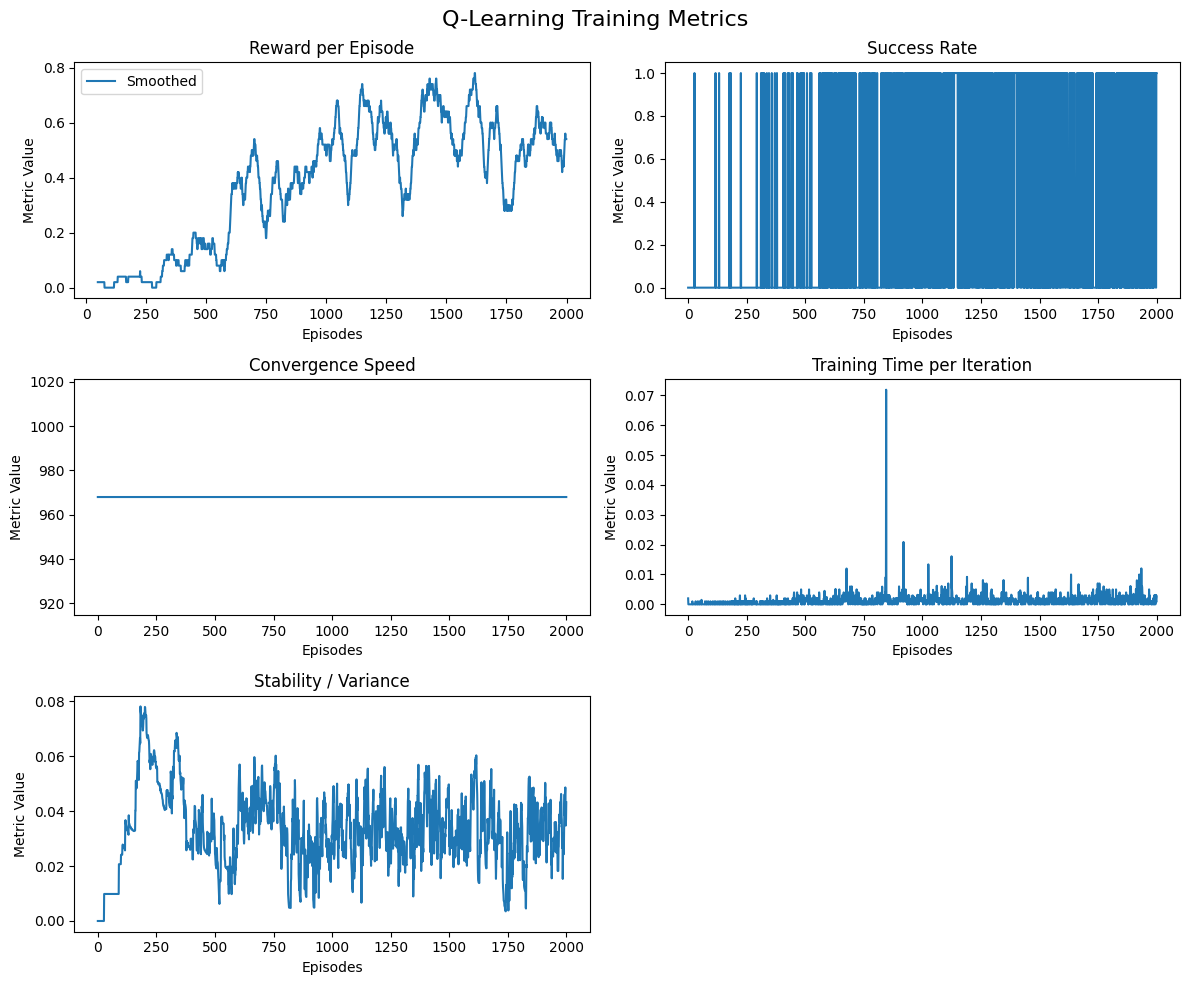

Training completed.
Converged at episode: 968
Final Q-table:
[[1.74845044e-01 1.41046721e-01 1.39920860e-01 1.30439728e-01]
 [5.63035657e-02 4.20185853e-02 3.64751635e-02 1.16227536e-01]
 [1.10236350e-01 5.58694626e-02 4.59019004e-02 2.86739375e-02]
 [9.07270508e-03 1.99638455e-04 1.32304990e-03 4.69412687e-02]
 [1.96136301e-01 1.11069847e-01 1.35715931e-01 1.43799132e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.30713453e-01 1.90887921e-02 3.90111150e-02 6.28836082e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.22384824e-01 1.85721496e-01 1.21961464e-01 2.67545015e-01]
 [1.63623915e-01 3.68103199e-01 2.30584063e-01 1.85971734e-01]
 [1.71504356e-01 4.02249909e-01 1.73547217e-01 3.71897757e-02]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.87592444e-01 2.74966312e-01 4.58942664e-01 1.95427313e-01]
 [3.48521488e-01 7.93447749e-01 5.36718230e-01 5.51175969

In [14]:
env = gym.make("FrozenLake-v1", is_slippery=True)
q_agent = QAgent(env)
action = input("train (or) load: ").strip().lower()
if action == "train":
    metrics = train_q_agent(q_agent, episodes=2000)
    plot_training_metrics(metrics)
    print(f"Training completed.")
    print(f"Converged at episode: {metrics['convergence_episode']}")
    print("Final Q-table:")
    print(q_agent.q_table)

elif action == "load":
    load_q_table(q_agent)
    plot_training_metrics(metrics)
    print(f"Training completed.")
    print(f"Converged at episode: {metrics['convergence_episode']}")
    print("Final Q-table:")
    print(q_agent.q_table)
else:
    print("Invalid input. Exiting...")
    exit()
play_game_with_graphics(q_agent)